# Dask Python Module Demo w/ UCI Student Data

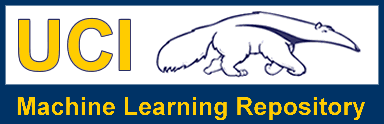

In [28]:
from IPython.display import Image
from IPython.core.display import HTML 

image1 = Image(filename="UCI_MLR.png", width=500)
display(image1)

### Objectives:

Using the UCI student-performance dataset, I will demonstrate several of Dask's best features. At a high level, Dask allows for a user to scale the machine learning and data structure packages within Python to multi-core computers and distributed computing clusters. There are three main advantages to Dask...
1. It can store data larger than what fits in RAM. 
2. It executes computations in parallel.
3. It includes a task scheduler.

The specific objectives are as follows...
1. Demonstrate delayed dask execution (reads, aggregations, etc...)
2. Demonstrate Dask reading in multiple files at once.
3. Construct 3 dask machine learning models
    - Linear Regression
    - Random Forrest
    - Kmeans Clustering
4. Use dask grid search to identify ideal parameters in parallel

From a practical standpoint, users experienced with Pandas and Sci-kit learn should be able to pick up and implement this package rather quickly.

__Resources:__
Location of dataset: https://archive.ics.uci.edu/ml/datasets/student+performance

__Attribute Information:__
1. school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira) 
2. sex - student's sex (binary: 'F' - female or 'M' - male) 
3. age - student's age (numeric: from 15 to 22) 
4. address - student's home address type (binary: 'U' - urban or 'R' - rural) 
5. famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3) 
6. Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart) 
7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary e.ducation or 4 â€“ higher education) 
8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary e.ducation or 4 â€“ higher education) 
9. Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
10. Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), '.at_home' or 'other') 
11. reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other') 
12. guardian - student's guardian (nominal: 'mother', 'father' or 'other') 
13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour) 
14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) 
15. failures - number of past class failures (numeric: n if 1<=n<3, else 4) 
16. schoolsup - extra educational support (binary: yes or no) 
17. famsup - family educational support (binary: yes or no) 
18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) 
19. activities - extra-curricular activities (binary: yes or no) 
20. nursery - attended nursery school (binary: yes or no) 
21. higher - wants to take higher education (binary: yes or no) 
22. internet - Internet access at home (binary: yes or no) 
23. romantic - with a romantic relationship (binary: yes or no) 
24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent) 
25. freetime - free time after school (numeric: from 1 - very low to 5 - very high) 
26. goout - going out with friends (numeric: from 1 - very low to 5 - very high) 
27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high) 
28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high) 
29. health - current health status (numeric: from 1 - very bad to 5 - very good) 
30. absences - number of school absences (numeric: from 0 to 93) 
31. G1 - first period grade (numeric: from 0 to 20) 
31. G2 - second period grade (numeric: from 0 to 20) 
32. G3 - final grade (numeric: from 0 to 20, output target)

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import dask_searchcv as dcv
import dask.dataframe as dd
from dask.distributed import Client 
from sklearn.externals.joblib import parallel_backend
from dask_ml.linear_model import LogisticRegression
from dask_ml.linear_model import LinearRegression
from dask_ml.preprocessing import StandardScaler
from dask_ml.model_selection import train_test_split
from sklearn.metrics import r2_score
import time
import glob

The files being read in with Dask are listed below. Here glob is being used to identify and group all of the files with student grade data.

In [2]:
#Printing the files found by glob
print(glob.glob('stu*.csv'))

#Read in data with dask
df = dd.read_csv(glob.glob('stu*.csv'), sep=';') 

['students_math_class.csv', 'students_portuguese_class.csv']


# Machine Learning Model (Tutorial)

Each machine learning model will use categorical and continuous variables to predict what the final grade for each student was. Prior to model building, the data will be preprocessed, scaled, and split into train and test. While the final predictive power of the models may not be very strong, this exercise is being done simply to showcase the functionality of the Dask package. 

To start, create a client. This command creates a local scheduler and worker, which manages resource allocation and computation execution. A deeper dive into the documentation for Dask can be found below...

__Dask Client Documentation__: http://distributed.dask.org/en/latest/client.html

In [3]:
# start a local Dask client
client = Client()

### Pre-process Data

Note that when defining the categorical columns, the 'Fedu' column was not included. This is because there are only two cases where the value is not 0, and thus it can create a constant column when splitting into train and test. Logic and process for id'ing this column as constant is commented out in the appendix of this notebook.

In [4]:
#Read in data with dask
df = dd.read_csv('students_math_class.csv', sep=';')

#Define categorical columns
cat_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu',\
            'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', \
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', \
            'internet', 'romantic']

#Convert to string so dask.get_dummies recognizes as categorical
cat_sub = df[cat_cols].astype(str)

#Creating dummies for the categorical variables
cat_dums = dd.get_dummies(cat_sub.categorize()).compute()

#Define continous columns
con_cols = ['age', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
con_sub = df[con_cols].astype('float64') #Convert to float for scaling purposes

#Merge categorical and continuous data
merge = dd.merge(con_sub, cat_dums, left_index=True, right_index=True)

#Converting to dask arrays for use in dask_ml 
X = merge.values.compute() #Inputs
y = df['G3'].values.astype(int).compute() #Target

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#Fit scaler on training data only! Transform both!
scaler = StandardScaler()
scaler.fit(X_train[:, :len(con_cols)]) #Fitting scaler on training data
X_train[:, :len(con_cols)] = scaler.transform(X_train[:, :len(con_cols)]) #Transforming train
X_test[:, :len(con_cols)] = scaler.transform(X_test[:, :len(con_cols)]) #Transforming test

Mixture of types in 'arrays'. Falling back to scikit-learn.


# Dask Linear Regression Model

Using the dask linear regression method, we fit the model on the training data and use it to predict the test data. 

In [34]:
#Fit dask linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

#Predict test values
y_pred = lr.predict(X_test)

#Evaluate accuracy of dask linear regression model
print("The R-squared value is:", round(r2_score(y_test, y_pred), 2))

The R-squared value is: 0.13


# Dask Random Forest Regression Model

Here we use the dask client's ability parallelize sklearn models to run a grid search for the optimal values of a random forest regression model. This shows the how easily dask can be integrated into existing code to take advantage of its performance. The below image from "AnalyticsVidhya.com" shows how dask grid search executes.

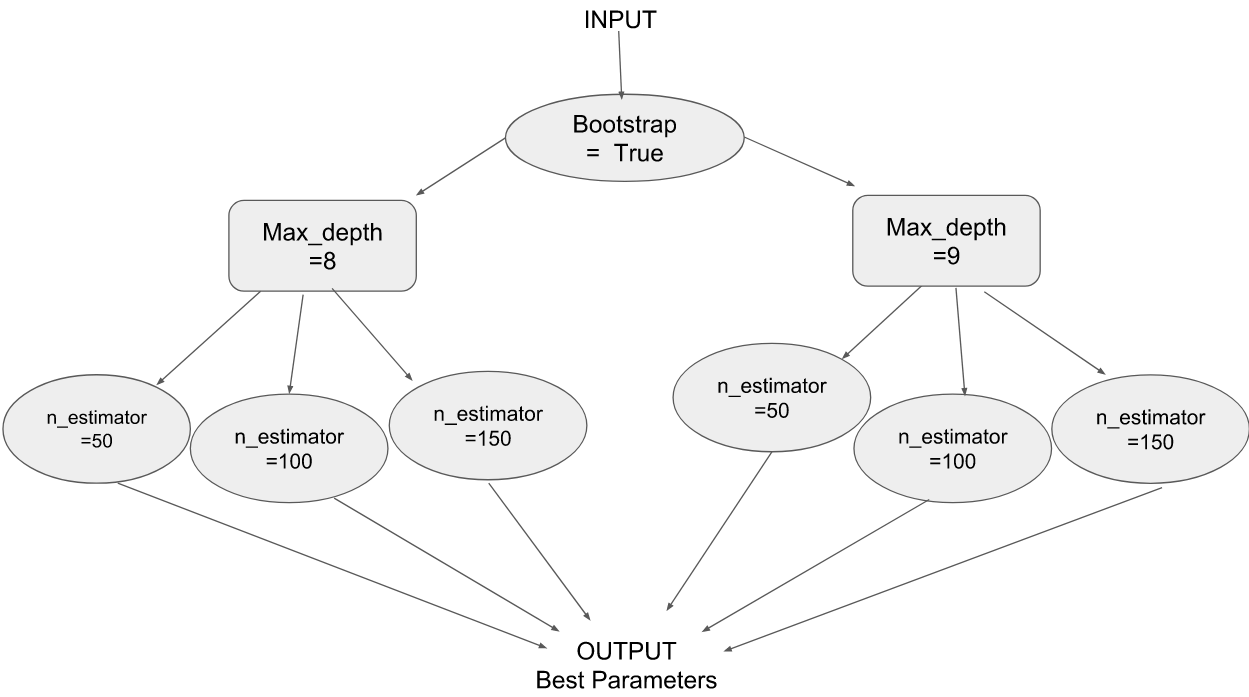

In [30]:
image2 = Image(filename="dask_grid_search.png", width=1000)
display(image2)

In [24]:
with parallel_backend('dask'):
    # Create the parameter grid based on the results of random search 
    param_grid = {'bootstrap': [True],
    'max_depth': [5, 10, 25, 50],
    'max_features': [2, 5, 10],
    'min_samples_leaf': [3, 5, 10],
    'min_samples_split': [3, 5, 10],
    'n_estimators': [50, 100, 250, 500]}

    # Create a based model
    from sklearn.ensemble import RandomForestRegressor #NOTE THAT THIS IS A PURE sklearn METHOD!!!
    rf = RandomForestRegressor()

In [25]:
# Instantiate the grid search model
grid_search = dcv.GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 100}

In [27]:
#Use the grid-searched random forest regressor model to predict the output of the test data
y_pred = grid_search.predict(X_test)

#Evaluate accuracy of dask linear regression model
print("The R-squared value is:", round(r2_score(y_test, y_pred), 2))

The R-squared value is: 0.23


# Dask KMeans Clustering

Using the dask KMeans clustering algorithm, we can specify the number clusters and predict which cluster future observations would fall in. This is a great example of dask's ability to parallelize unsupervised learning models. 

In [9]:
from dask_ml.cluster import KMeans
model = KMeans(n_clusters=3, random_state=0)
model.fit(X_train)

C:\Users\mikes\Anaconda3\lib\site-packages\dask\array\top.py:698: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  contains = index in indices


KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=None,
    max_iter=300, n_clusters=3, n_jobs=1, oversampling_factor=2,
    precompute_distances='auto', random_state=0, tol=0.0001)

In [10]:
#Outputting the predicted clusters for the test data
model.predict(X_test).compute()

array([0, 2, 0, 1, 1, 1, 1, 2, 2, 0, 0, 2, 1, 1, 0, 1, 0, 0, 2, 1, 1, 2,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 0, 1, 1])

# Takeaways

Using dask, we were able to run methods with delayed execution, read and concatenate multiple files at once, utilize the dask ml library for linear regression and KMeans models, parallelize the existing sklearn random forest regressor model, and use dask grid search to identify best parameters. I hope you found this content useful, and best of luck using these tools in future analysis!

# Appendix

### *Constant Column Identification and Exclusion

In [11]:
# constants = pd.DataFrame(X_train)
# constants.head()
# constant_cols = constants.max(axis=0) == constants.min(axis=0)
# constant_cols.sum()
# #27- (8 continous columns)  means access categorical column 19
# cat_dums.iloc[:, 19].value_counts()
# constant_cols.loc[constant_cols == 1]